# Индивидуальное задание по ML. Тема: Boosting (Bank Churn)

## Условие и кто выполнил

Цель - предсказать, продолжит ли клиент пользоваться своим аккаунтом или закроет его

Модель: XGBoost

Должно быть выполнено:

1. Исследовательский анализ данных (EDA)
2. Предварительная обработка данных
3. Построение и оценка модели

Выполнил: студент группы 5030102/10201 Карасев Вячеслав Алексеевич

## Решение


### Исследовательский анализ данных (EDA)

Для начала импортируем необходимые библиотеки:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from xgboost import XGBClassifier

`pandas` будет необходим для работы с табличными значениями, `numpy` - для удобства работы с матрицами и векторами, `seaborn` и `matplotlib` - для визуализации данных, `sklearn` - для разделения выборок и удобства вычисления метрик, и непосредственно `xgboost` - для самой модели градиентного бустинга.

Для начала загрузим наши данные и выведем общую информацию:

In [3]:
train_data = pd.read_csv('data.csv')

print('Information about train data: ')
print(train_data.head()) 
print(train_data.info()) 


Information about train data: 
   id  CustomerId         Surname  CreditScore Geography Gender   Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male  33.0       3   
1   1    15749177   Okwudiliolisa          627    France   Male  33.0       1   
2   2    15694510           Hsueh          678    France   Male  40.0      10   
3   3    15741417             Kao          581    France   Male  34.0       2   
4   4    15766172       Chiemenam          716     Spain   Male  33.0       5   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              2        1.0             0.0        181449.97   
1       0.00              2        1.0             1.0         49503.50   
2       0.00              2        1.0             0.0        184866.69   
3  148882.54              1        1.0             1.0         84560.88   
4       0.00              2        1.0             1.0         15068.83   

   Exited  
0       0  
1      

Из хороших новостей сразу видно, что отсутствуют NULL значения, поэтому можно не очищать датасет от этих значений. Переменная, которая нас интересует - это `Exited`, то есть ушел ли клиент из банка или нет, поэтому имеем задачу бинарной классификации. Посмотрим на распределение `Exited`:

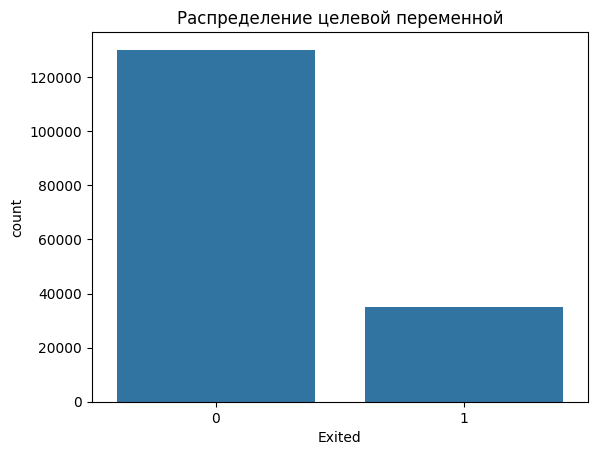

In [4]:
sns.countplot(x='Exited', data=train_data)
plt.title('Распределение целевой переменной')
plt.show()

К сожалению, классы несбалансированны (большая часть клиентов не уходит из банка), поэтому при обучении модели мы должны это учесть.

Посмотрим на корреляцию `Exited` с другими числовыми данными.

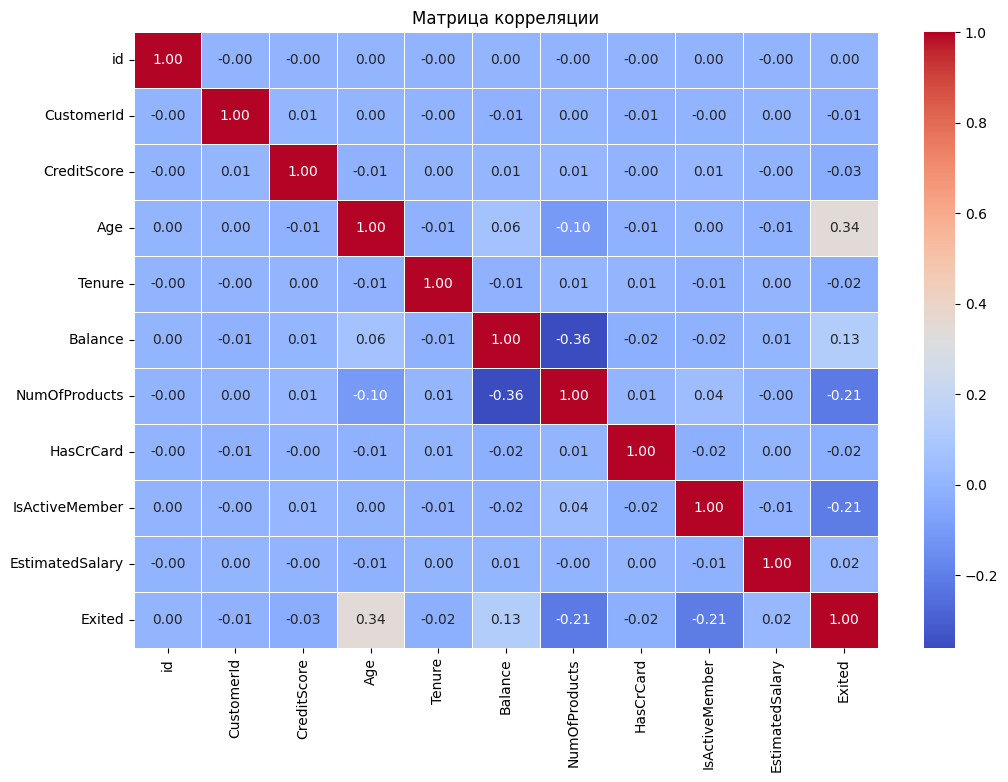

In [5]:
numeric_data = train_data.select_dtypes(include=['number'])

correlation_matrix = numeric_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Матрица корреляции')
plt.show()

Сразу заметно, что на `Exited` влияют возраст, активность клиента и кол-во его продуктов. Чуть меньше влияет баланс клиента.

Однако надо разобраться также с корреляцияей с категориальными данными. Для этого предварительно закодируем их.

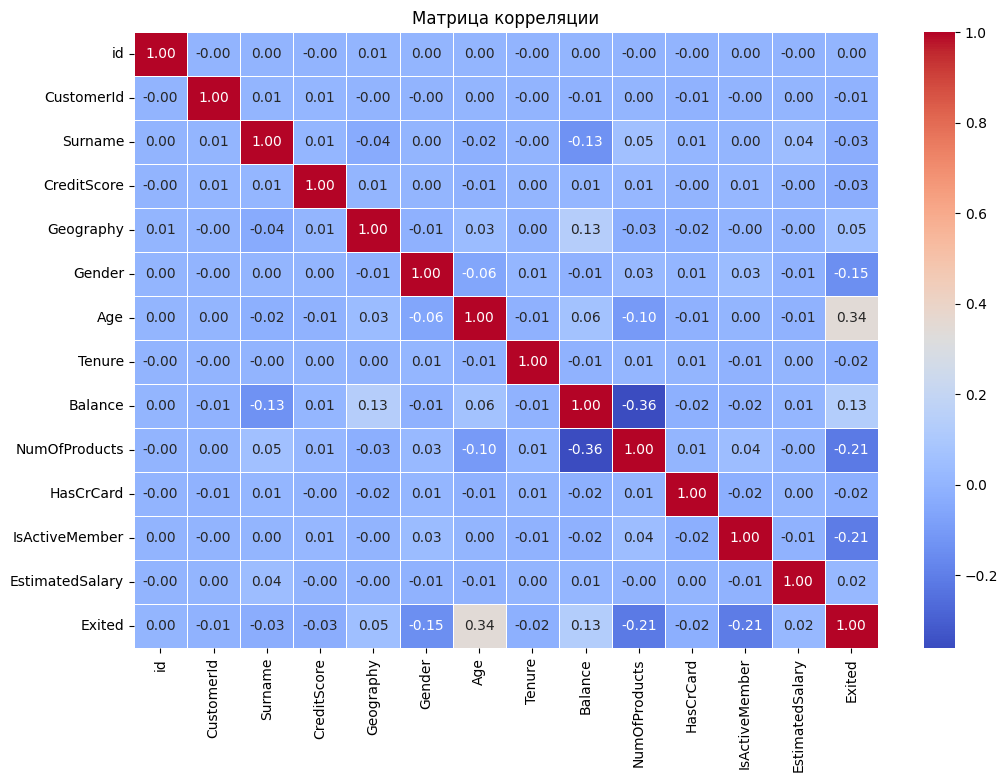

In [6]:
categorical_columns = train_data.select_dtypes(include=['object']).columns
encoder = LabelEncoder()

for col in categorical_columns:
    train_data[col] = encoder.fit_transform(train_data[col])

numeric_data = train_data.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Матрица корреляции')
plt.show()

Теперь заметно, что `Exited` коррелирует также с полом клиента и, менее, с его географией. Однако из общих соображений учтем и эти параметры.

### Предварительная обработка данных

Для начала закодируем обычным one-hot кодированием категориальные переменные:

In [7]:
train_data = pd.get_dummies(train_data, drop_first=True)

Теперь сформируем датасеты для обучения и тестирования. Предварительно, оставим для обучения только те данные, которые по результатам EDA влияют больше всего, а остальные удалим. Естественно, удалим также и `Exited`.

In [8]:
X = train_data.drop(columns=['Exited', 'CustomerId', 'Surname', 'CreditScore', 'Tenure', 'HasCrCard', 'EstimatedSalary', 'id'])
y = train_data['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

Параметр `stratify` необходим для равномерного распределения наших двух классов по тренировочной и валидационной выборке, так как классы несбалансированны.

Последний шаг, который остался: взвесить классы и учесть это при построении и обучении модели. Формула для параметра `scale_pos_weight` взята из официальной документации XGBoost

In [9]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

### Построение и оценка модели

Инициализируем модель XGBoost, в конструктор передадим параметр сдвига по весам:

In [10]:
model = XGBClassifier(scale_pos_weight=scale_pos_weight)

Наконец, обучим нашу модель:

In [11]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Теперь самое время оценить результаты. Для этого сначала посчитаем численно AUC-ROC Score и выведем краткий отчет о классификации, включающем в себя recall, precision и f1-score.

In [12]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))

AUC-ROC Score: 0.8869054437877427
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.83      0.88     26023
           1       0.55      0.78      0.64      6984

    accuracy                           0.82     33007
   macro avg       0.74      0.80      0.76     33007
weighted avg       0.85      0.82      0.83     33007



Модель обучилась **неплохо**, о чем свидетельствует высокий AUC-ROC (0.88) и f1-score (0.76 в среднем). Для лучшей визуализации построим матрицу ошибок:

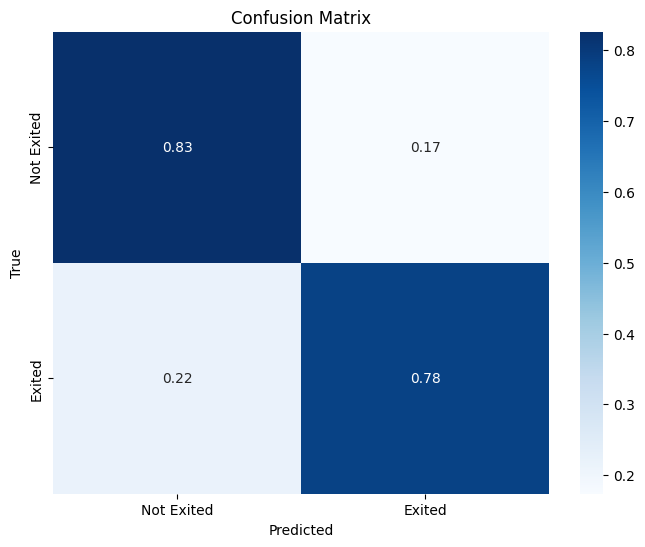

In [13]:
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Not Exited", "Exited"], yticklabels=["Not Exited", "Exited"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Отчетливо выделяется диагональ - это свидетельствует о том, что классификатор справляется со своей задачей определять отток клиента.

Так как мы работаем с бинарным классификатором, можем позволить себе такую роскошь, как ROC-кривую:

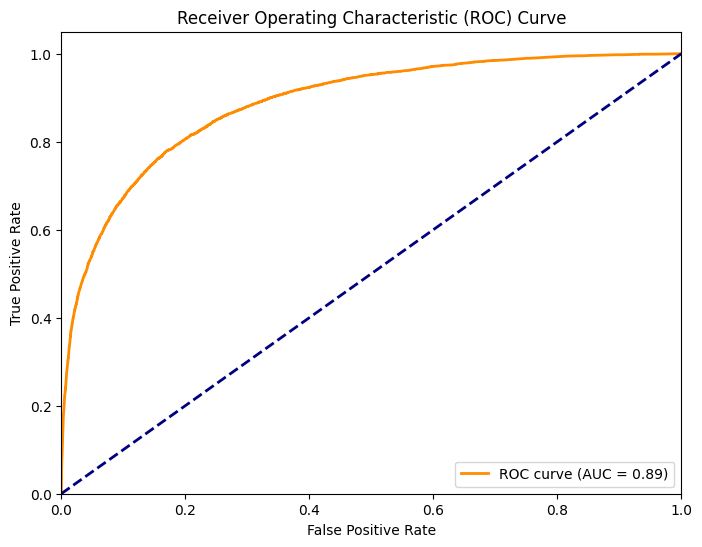

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_prob = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Удалось обучить хороший работоспособный классификатор. Посмотрим на анализ важности признаков - какие переменные вносят наибольшее влияние при предсказаниях. В контексте XGBoost - сколько раз признак был использован для разделений в деревьях. Для этого воспользуемся функцией `plot_importance`, поставляемой из коробки вместе с самим бустингом.

<Figure size 1000x800 with 0 Axes>

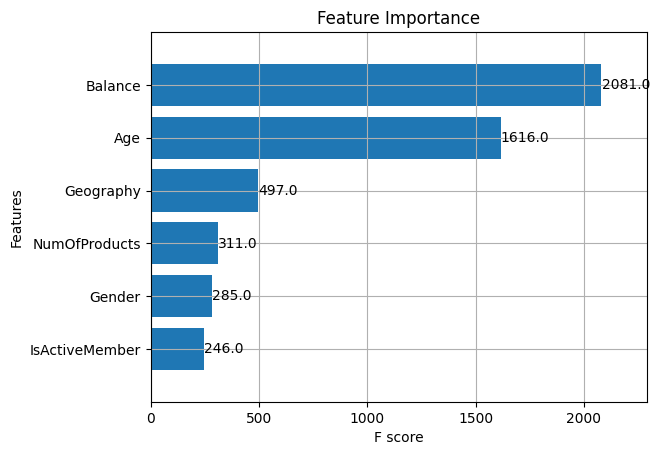

In [15]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(10, 8))
plot_importance(model, importance_type='weight', height=0.8)
plt.title('Feature Importance')
plt.show()

Любопытно, что количество используемых продуктов и активность клиента вносят гораздо меньший вклад, чем остальные признаки. В этом есть рациональное зерно - обычно клиенты уходят из банка в связи с какими-то неприятными событиями в банке или в своей жизни, и параметры выше не так сильно важны при таком решении.